### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [1]:
import urllib2
import PIL
import os
import numpy as np

# for image manipulation. Easier to do 
# here than with Keras, as per
# https://piazza.com/class/ivlbdd3nigy3um?cid=818
#!sudo pip install Image
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


## Step One: Extracting Movies From URL 

In [3]:
# train = pd.read_csv("train_full.csv")
# train.drop("Unnamed: 0", axis=1, inplace=True)
# print "Train shape:", train.shape
# train.head(1)

In [4]:
train_thinned = pd.read_csv("train.csv")
train_thinned.drop("Unnamed: 0", axis=1, inplace=True)
print "train_thinned shape:", train_thinned.shape
train_thinned.head(1)

train_thinned shape: (540, 29)


,10402,10749,10751,10752,12,14,16,18,27,28,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,1,0,0,0,1,0,0,0,...,"[u'Alec Baldwin', u'Miles Bakshi', u'Jimmy Kim...",295693,A story about how a new baby's arrival impacts...,305.881041,/unPB1iyEeTBcKiLg8W083rlViFH.jpg,2017-03-23,The Boss Baby,False,5.7,510


## Important. 

The line below aliases the DF that we want to work with as `curr_df`. When we decide later on to use the full training set instead of just `train_thinned`, all we need to do is set it in the cell below and re-run the code. This will prevent us from having to find/replace all instances of the past dataframe.

In [5]:
curr_df = train_thinned

In [6]:
## Helper that downloads web images 
## Takes in the poster path and the id of the movie 
## Saves the movie as a jpg as the unique id of the movie 
## In the images folder.
def download_web_image(poster_path, movie_id):
    # given that we're going to resize our images to be 32x32
    # or something else really small, let's download really small images 
    # to start
    base_url = "https://image.tmdb.org/t/p/w92/" 
    
    request = urllib2.Request(base_url + poster_path)
    img = urllib2.urlopen(request).read()
    image_name= "images/" + str(movie_id) + ".jpg"
    
    with open(image_name, 'w') as f: 
        f.write(img)

In [7]:
### iterate through all of the images in the thinned dataset, saving locally 
if 1:
    print "If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images."
else:
    for index, row in curr_df.iterrows():
        movie_id = row["movie_id"]
        poster_path = row["poster_path"] 
#         download_web_image(poster_path, movie_id)

If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images.


In [8]:
img_rows, img_cols = 299, 299

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("images/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("images/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        out.save("nn_ready_images/" + img_name)

# 1. Building a CNN from Scratch

### Data Wrangling

In [9]:
# number of labels in our output
n_labels = 17

In [10]:
# now we need training and testing data. in the current state,
# we have a bunch of greyscale images named by their movie ids.
# to get the data, we can first just split all the movie ids (X) in the
# dataframe intro train and test sets, and then grab their multilabel
# matrices (y)
m_ids = curr_df.movie_id.values

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)

import math
train_size = int(math.floor(.7 * len(m_ids)))

# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [11]:
# these are the column names of the multilabel matrix
label_names = curr_df.columns[:n_labels]

y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", y_train.shape
print "y_test shape:", y_test.shape

y_train shape: (378, 17)
y_test shape: (162, 17)


In [12]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512

# number of iterations over the complete training data
epochs = 30

In [13]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [14]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train.shape
print "x_test shape:", x_test.shape

x_train shape: (378, 299, 299)
x_test shape: (162, 299, 299)


In [15]:
# code borrowed from Keras_CNN lab

# now we need to reshape x_train and x_test so that they work with CNNs
# Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
# of images with shape determined by the backend, including the depth dimension,
# which is 1 for greyscale

# x_train is of shape n_samples x 32 x 32
# for a CNN we want to keep the image shape
# need to explicitly tell keras that it is a gray value image
# so each image is 32x32x1 not 32x32x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# normalize image values to [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 25

print "x_train shape:", x_train.shape
print x_train.shape[0], "train samples"
print x_test.shape[0], "test samples"

x_train shape: (378, 299, 299, 1)
378 train samples
162 test samples


### Model Architecture

In [16]:
# Wrapper for our CNN from scratch
# We treat the number of layers, filter size, kernel size, and activation function as 
# 'parameters' that we can "tune"

def CNN_from_scratch(n_layers, filters, kernels, activation_function):
    # create an empty network model
    model = Sequential()
    
    for i in n_layers:
        # define the input layer to the CNN
        # input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
        # the first parameter to Conv2D is the number of filters we want to convolve
        # over the input images

        model.add(Conv2D(filters[i], kernel_size=kernels[i], 
                         activation=activation_function, input_shape=input_shape))

        # create a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten for fully connected classification layer
    model.add(Flatten())

    # note that the 10 is the number of classes we have
    # the classes are mutually exclusive so softmax is a good choice
    # --- fully connected layer ---
    model.add(Dense(64, activation='relu'))

    # recommended by: https://github.com/fchollet/keras/issues/761
    # uses a sigmoid activation rather than softmax, which apparently
    # gives us a label vector back
    model.add(Dense(n_labels, activation='sigmoid'))

    # prints out a summary of the model architecture
    model.summary()

    # the setup is our basic categorical crossentropy with stochastic gradient decent
    # we also specify that we want to evaluate our model in terms of accuracy
    sgd = SGD(lr=0.1, momentum=0.9)

    # TODO: why are we using binary crossentropy?
    # I'm not sure, but it works much better than
    # categorical crossentropy.
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    # this is now the actual training
    # in addition to the training data we provide validation data
    # this data is used to calculate the performance of the model over all the epochs
    # this is useful to determine when training should stop
    # in our case we just use it to monitor the evolution of the model over the training epochs
    # if we use the validation data to determine when to stop the training or which model to save, we 
    # should not use the test data, but a separate validation set. 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    
    # once training is complete, let's see how well we have done
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return score

In [17]:
# training the CNN from scratch, save test loss
# uses 64x64 images

model_losses = []
model_accuracies = []

# use 1 layer
results = CNN_from_scratch(n_layers=range(1), filters=[8], 
                           kernels=[(3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

# add 2nd layer
results = CNN_from_scratch(n_layers=range(2), filters=[8, 16], 
                           kernels=[(3, 3), (3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

# add 3rd layer
results = CNN_from_scratch(n_layers=range(3), filters=[8, 16, 32], 
                           kernels=[(3, 3), (3, 3), (3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

# add 4th layer
results = CNN_from_scratch(n_layers=range(4), filters=[8, 16, 32, 64], 
                           kernels=[(3, 3), (3, 3), (3, 3), (3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

# add 5th layer
results = CNN_from_scratch(n_layers=range(5), filters=[8, 16, 32, 64, 128], 
                           kernels=[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

# add 6th layer
results = CNN_from_scratch(n_layers=range(6), filters=[8, 16, 32, 64, 128, 256], 
                           kernels=[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)], activation_function='relu')
model_losses.append(results[0])
model_accuracies.append(results[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 297, 297, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 8)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                11214912  
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 11,216,097.0
Trainable params: 11,216,097.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 378 samples, validate on 162 samples
Epoch 1/30
378/378 [==============================] - 5s - loss: 0.6845 - acc:

In [18]:
model_losses

[1.4781560471028456,
 0.4348837740627336,
 0.477556124145602,
 0.45766427855432767,
 0.44713792646372758,
 0.77307350326467439]

In [19]:
model_accuracies

[0.72839509263450719,
 0.8111837484218456,
 0.82897606160905624,
 0.82933917604846719,
 0.82933917604846719,
 0.82933917604846719]

In [23]:
if False:
    print 'reassigned'
    model_losses_299 = model_losses[:]
    model_accuracies_299 = model_accuracies[:]

In [21]:
model_losses_299

[1.4781560471028456,
 0.4348837740627336,
 0.477556124145602,
 0.45766427855432767,
 0.44713792646372758,
 0.77307350326467439]

In [22]:
model_accuracies_299

[0.72839509263450719,
 0.8111837484218456,
 0.82897606160905624,
 0.82933917604846719,
 0.82933917604846719,
 0.82933917604846719]

In [45]:
if False:
    print 'reassigned'
    model_losses_64 = model_losses[:]
    model_accuracies_64 = model_accuracies[:]

In [46]:
model_losses_64

[0.57086285985546348,
 0.64759598911544425,
 0.65746877664401204,
 1.0032658753571686]

In [47]:
model_accuracies_64

[0.83006536960601807,
 0.82933916427471022,
 0.82207697556342607,
 0.82933917604846719]

# Tuning our CNN from Scratch

Per this quora answer: https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN

### On Kernels
- For kernel size, in general, smaller + deeper kernels are better
- Deeper networks are generally better (more layers), at the cost of more data required and increased learning complexity

### On batch
- batch size should be a few hundred

### On Filters
- initially should use fewer filters and gradually increase and monitor the error rate to see how it is varying
- very small filter sizes will capture very fine details of the image, bigger filters will leave out minute details in the image
- common kernel sizes are 3x3, 5x5, and 7x7
- 

In [127]:

# create an empty network model
model = Sequential()

# define the input layer to the CNN
# input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
# the first parameter to Conv2D is the number of filters we want to convolve
# over the input images
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolution layer
# we could double the number of filters as max pool made the 
# feature maps much smaller, but we're not doing this to improve runtime
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
#model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

#model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
#model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
#model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

# flatten for fully connected classification layer
model.add(Flatten())

# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))

# recommended by: https://github.com/fchollet/keras/issues/761
# uses a sigmoid activation rather than softmax, which apparently
# gives us a label vector back
model.add(Dense(n_labels, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 298, 298, 8)       80        
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 149, 149, 8)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 177608)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                11366976  
_________________________________________________________________
dense_24 (Dense)             (None, 17)                1105      
Total params: 11,368,161
Trainable params: 11,368,161
Non-trainable params: 0
_________________________________________________________________


### Compile the model

Let's use a large learning rate (0.1) while we're working locally

In [114]:
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)

# TODO: why are we using binary crossentropy?
# I'm not sure, but it works much better than
# categorical crossentropy.
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Train the model

In [115]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 378 samples, validate on 162 samples
Epoch 1/30
378/378 [==============================] - 4s - loss: 0.6852 - acc: 0.5451 - val_loss: 0.6490 - val_acc: 0.6576
Epoch 2/30
378/378 [==============================] - 1s - loss: 0.6668 - acc: 0.6754 - val_loss: 0.5985 - val_acc: 0.7407
Epoch 3/30
378/378 [==============================] - 1s - loss: 0.6336 - acc: 0.7557 - val_loss: 0.7085 - val_acc: 0.7709
Epoch 4/30
378/378 [==============================] - 1s - loss: 0.5840 - acc: 0.7859 - val_loss: 1.0175 - val_acc: 0.7869
Epoch 5/30
378/378 [==============================] - 2s - loss: 0.5180 - acc: 0.7943 - val_loss: 1.4440 - val_acc: 0.8152
Epoch 6/30
378/378 [==============================] - 2s - loss: 0.4668 - acc: 0.8184 - val_loss: 1.7369 - val_acc: 0.8195
Epoch 7/30
378/378 [==============================] - 1s - loss: 0.4661 - acc: 0.8220 - val_loss: 1.9386 - val_acc: 0.8290
Epoch 8/30
378/378 [==============================] - 1s - loss: 0.4865 - acc: 0.8262 - val_l

In [116]:
# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.82848376771550125)
('Test accuracy:', 0.82098762635831479)


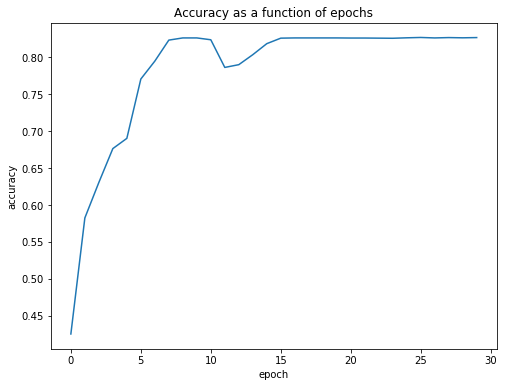

In [84]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(history.history['acc'])
plt.title("Accuracy as a function of epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")

# ToDos for #1
1. Binary Categorization?
2. Accuracy?
3. Last layer for doing multilabel (is sigmoid correct?)

# 2. Fine tuning a pre-trained model

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

### Convert Images to Format for InceptionV3 

In [22]:
### Because inception takes in a 299 x 299 RGB image, we need to download them as such 
img_rows, img_cols = 299, 299

# convert each normal poster to a 299x299 poster
for img_name in os.listdir("images/"):
    if not img_name.startswith('.'):
        # read in an image, do not convert to greyscale 
        im = Image.open("images/" + img_name)
        out = im.resize((img_rows, img_cols))
        ## save to the inception images folder 
        out.save("inception_ready_images/" + img_name)

In [23]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("inception_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("inception_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [24]:
## Our data is of the format that we can use for inception 
x_train.shape

(378, 299, 299, 3)

In [25]:
x_test.shape

(162, 299, 299, 3)

In [26]:
type(y_train)

numpy.ndarray

In [27]:
## convert data into tuple of training data
## model.fit_generator takes a tuple 
training = (x_train, y_train)

test = (x_test, y_test)


In [28]:
# create the base pre-trained model
base_model = InceptionV3(weights= 'imagenet', include_top=False)

In [29]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

In [30]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
# model.fit_generator(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, y_test))

In [31]:
model.fit(x_train, y_train)

ValueError: Error when checking model target: expected dense_4 to have shape (None, 200) but got array with shape (378, 17)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

# 3. Discussion of the results, how much improvement you gained with fine tuning, etc. 

# 4. Discussion of at least one additional exploratory idea you pursued 